In [1]:
# set jupyter auto reload and 2
%load_ext autoreload
%autoreload 2
from omegaconf import OmegaConf
import torch
from torch.optim import lr_scheduler
import torch.nn as nn

from tqdm import tqdm
from utils.train_utils import select_device, fix_seed, log_images, calculate_metrics_fromloader, pred_fn, image_float2int
from utils.builder import build_data, build_models, build_optimizer
import torch.nn.functional as F
import wandb
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
from tqdm import tqdm

# wandb.login(key="d86336fbe1e8b0ef444fa1f7f67208a1333b7176")
print("logged in ")



/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logged in 


In [2]:
wandb.finish()
assert wandb.run is None
wandb.init(project="Eye2Gene", entity="pstha", name="res_VAE_oct_no_feature")
print("init")

wandb: Currently logged in as: pstha. Use `wandb login --relogin` to force relogin


init


In [3]:
configs = OmegaConf.load('./config/mae/vae_kaggle_oct_small.yaml')
gpus = select_device('0', configs.data.batch_size)
fix_seed(2023)
train_loader, val_loader, test_loader = build_data(configs)

In [11]:
# create loaders for mnist
from torchvision.datasets import MNIST
from torchvision import transforms

#upscale to 64 by 64 during transform
train_dataset = MNIST("/mnt/Enterprise/prashant/mnist/", train = True, download=True, transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
test_dataset = MNIST("/mnt/Enterprise/prashant/mnist/", train = False, download=True, transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
]))
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size)


 ... (more hidden) ...


Extracting /mnt/Enterprise/prashant/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /mnt/Enterprise/prashant/mnist/MNIST/raw



 ... (more hidden) ...

Extracting /mnt/Enterprise/prashant/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /mnt/Enterprise/prashant/mnist/MNIST/raw



 ... (more hidden) ...


Extracting /mnt/Enterprise/prashant/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnt/Enterprise/prashant/mnist/MNIST/raw



 ... (more hidden) ...

Extracting /mnt/Enterprise/prashant/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnt/Enterprise/prashant/mnist/MNIST/raw



torch.Size([3, 64, 64])


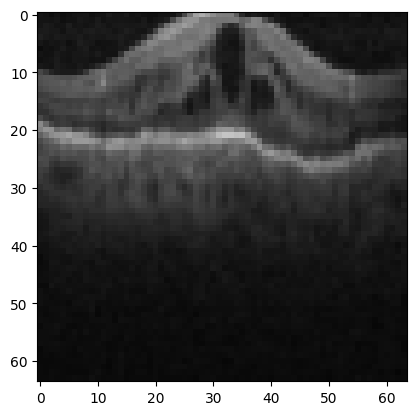

torch.Size([3, 64, 64])


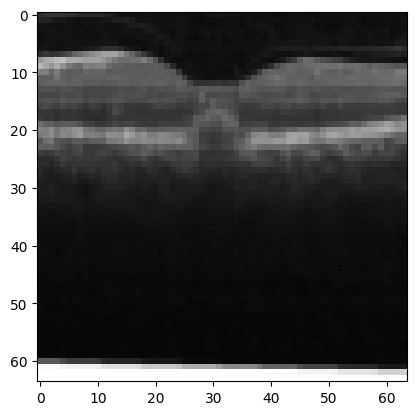

torch.Size([3, 64, 64])


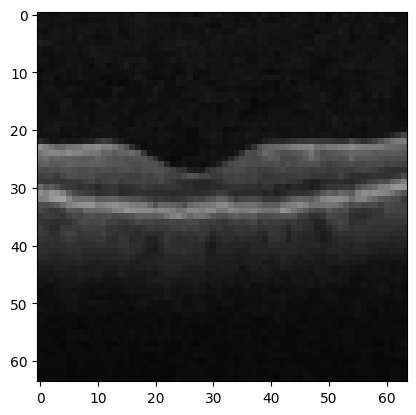

torch.Size([3, 64, 64])


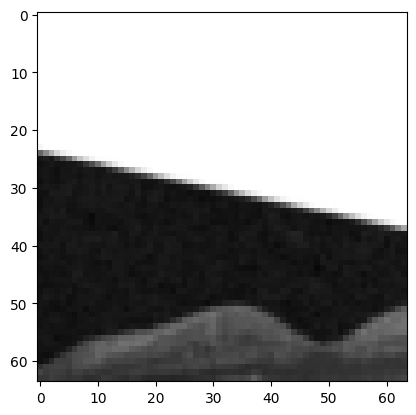

torch.Size([3, 64, 64])


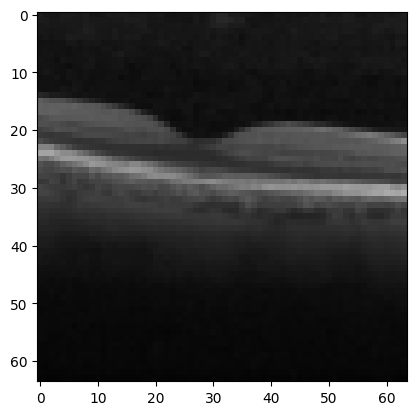

torch.Size([3, 64, 64])


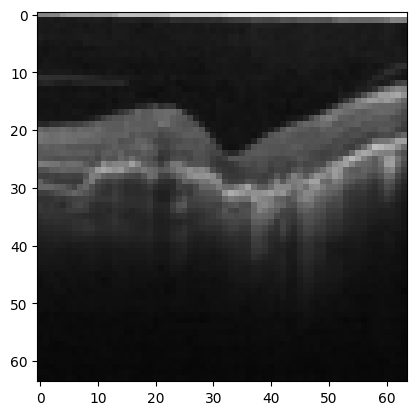

torch.Size([3, 64, 64])


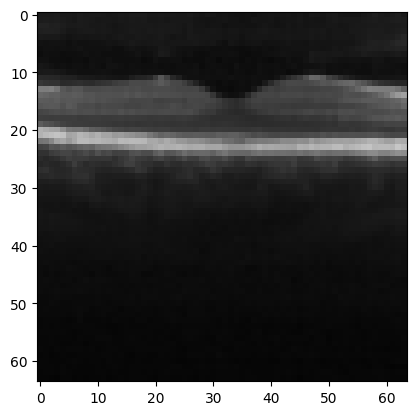

torch.Size([3, 64, 64])


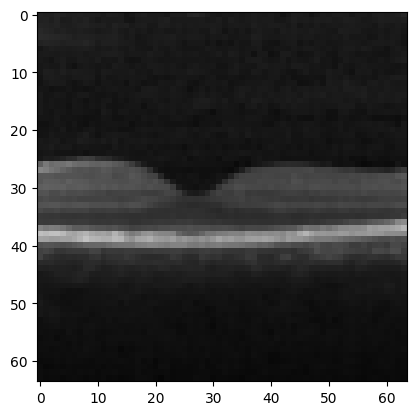

torch.Size([3, 64, 64])


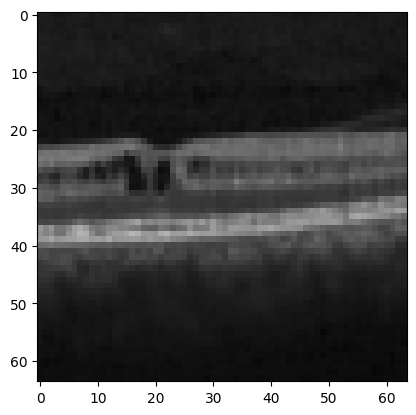

torch.Size([3, 64, 64])


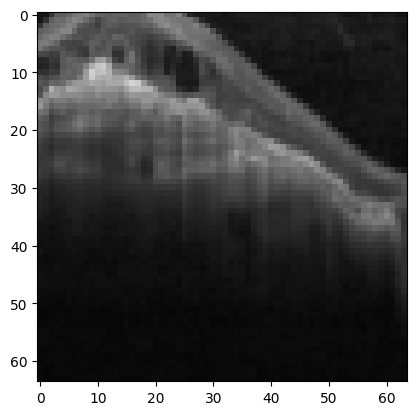

torch.Size([3, 64, 64])


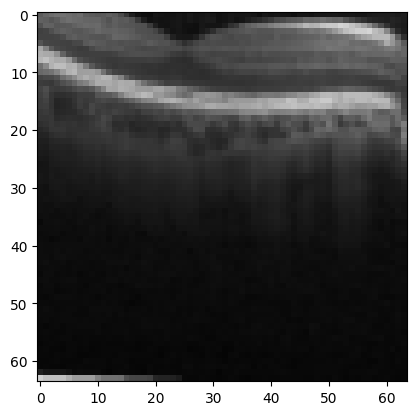

In [6]:
# print few images
for batch in train_loader:
    try:
        images = batch["image"]
    except:
        images = batch[0]
    for i in range(images.size()[0]):
        print(images[i].shape)
        plt.imshow(images[i].permute(1,2,0).numpy())
        plt.show()
        if i == 10:
            break
    break
    

In [7]:
def kl_loss_fn(mu, logvar):
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

import torch.nn as nn
import torch


class VGG19(nn.Module):
    """
     Simplified version of the VGG19 "feature" block
     This module's only job is to return the "feature loss" for the inputs
    """

    def __init__(self, channel_in=3, width=64):
        super(VGG19, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, width, 3, 1, 1)
        self.conv2 = nn.Conv2d(width, width, 3, 1, 1)

        self.conv3 = nn.Conv2d(width, 2 * width, 3, 1, 1)
        self.conv4 = nn.Conv2d(2 * width, 2 * width, 3, 1, 1)

        self.conv5 = nn.Conv2d(2 * width, 4 * width, 3, 1, 1)
        self.conv6 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv7 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv8 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)

        self.conv9 = nn.Conv2d(4 * width, 8 * width, 3, 1, 1)
        self.conv10 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv11 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv12 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.conv13 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv14 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv15 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv16 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.load_params_()

    def load_params_(self):
        # Download and load Pytorch's pre-trained weights
        state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth')
        for ((name, source_param), target_param) in zip(state_dict.items(), self.parameters()):
            target_param.data = source_param.data
            target_param.requires_grad = False

    def feature_loss(self, x):
        return (x[:x.shape[0] // 2] - x[x.shape[0] // 2:]).pow(2).mean()

    def forward(self, x):
        """
        :param x: Expects x to be the target and source to concatenated on dimension 0
        :return: Feature loss
        """
        x = self.conv1(x)
        loss = self.feature_loss(x)
        x = self.conv2(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 64x64

        x = self.conv3(x)
        loss += self.feature_loss(x)
        x = self.conv4(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 32x32

        x = self.conv5(x)
        loss += self.feature_loss(x)
        x = self.conv6(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv7(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv8(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 16x16

        x = self.conv9(x)
        loss += self.feature_loss(x)
        x = self.conv10(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv11(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv12(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 8x8

        x = self.conv13(x)
        loss += self.feature_loss(x)
        x = self.conv14(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv15(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv16(self.relu(x))
        loss += self.feature_loss(x)

        return loss/16


In [8]:
from models.res_vae import VAE
loss_log = []
nepoch = 100
start_epoch = 0

device = 'cuda:0'
vae_net = VAE(channel_in=3, ch=64).to(device)
# setup optimizer
lr = 1e-4
optimizer = torch.optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))

In [45]:


# load checkpoint
ckpt = torch.load('/mnt/Enterprise/prashant/logs/VAE_latest.pth')
vae_net.load_state_dict(ckpt['vae_net'])
optimizer.load_state_dict(ckpt['optimizer'])
start_epoch = ckpt['epoch']
#best_loss = ckpt['best_loss']
print('Loaded checkpoint from epoch %d.' % start_epoch)



Loaded checkpoint from epoch 35.


In [9]:

#Loss function

feature_extractor = VGG19().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/prashant/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
 ... (more hidden) ...


In [11]:
def plot_tsne(model, data_loader, config, title='val set'): 
    model.eval()
    X = []
    X_labels = []
    for batch in tqdm(data_loader):
        features, _, _ = model.encoder(batch["image"].to(device))
#         features, _, _ = model.encoder(batch[0].to(device))
        
        features = features.view(features.size(0), -1)
        labels = batch["label"].to(device)
        X.append(features.detach().cpu().numpy())
        X_labels.append(labels.detach().cpu().numpy())

    # get X and X labels
    X = np.concatenate(X, axis=0)
    X_labels = np.concatenate(X_labels, axis=0)
    print(X.shape, X_labels.shape)
    
    k = 4

    # Create a KMeans object
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # Get the labels for each data point
    kmeans_labels = kmeans.labels_

    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(X)
    dftsne = pd.DataFrame(tsne_embeddings)
    dftsne['cluster'] = pd.Series(X_labels)
    dftsne.columns = ['x1','x2','cluster']
    
    dftsne_kmeans = dftsne.copy()
    dftsne_kmeans['cluster'] = kmeans_labels
    os.makedirs(f"output/{config.model_type}", exist_ok=True)
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",palette="deep", alpha=0.5).set_title(title + ", cluster colors using ground truth")
    plt.show()
    wandb.log({"tsne_plot": wandb.Image(plt)})
    # plt.savefig(f"output/{config.model_type}/tsne_gt.png")
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dftsne_kmeans,x='x1', y='x2', hue='cluster', legend='full', palette="deep", alpha=0.5).set_title(title+", cluster colors using k means")
    plt.show()
    # plt.savefig(f"output/{config.model_type}/tsne_kmeans.png")

    print(title, metrics.rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))
    print(title, metrics.adjusted_rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...

Train error for epoch 1: 0.043838268499857176


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...


Val error for epoch 1: 0.04736321100166866


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

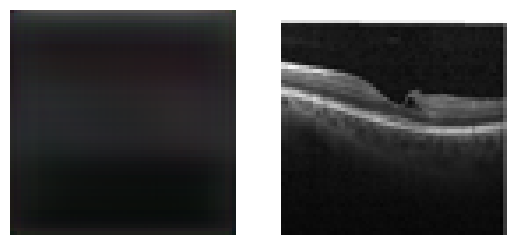

 ... (more hidden) ...
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


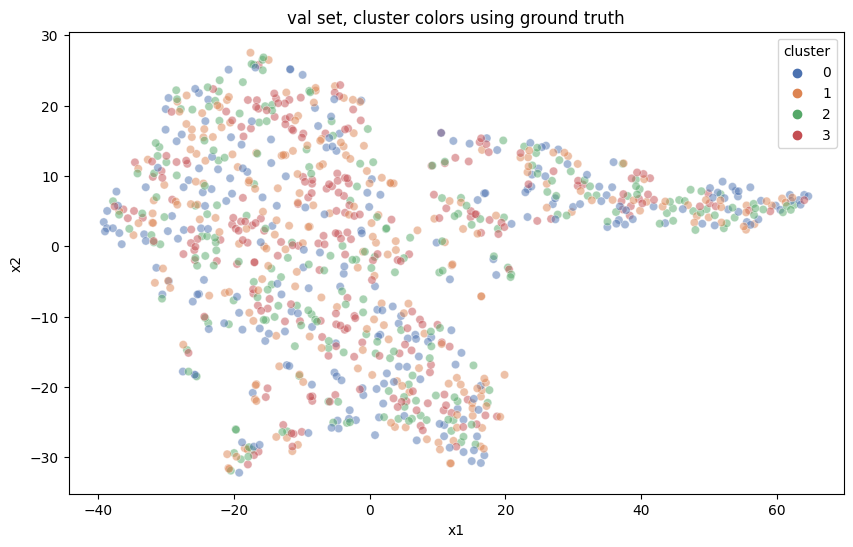

<Figure size 640x480 with 0 Axes>

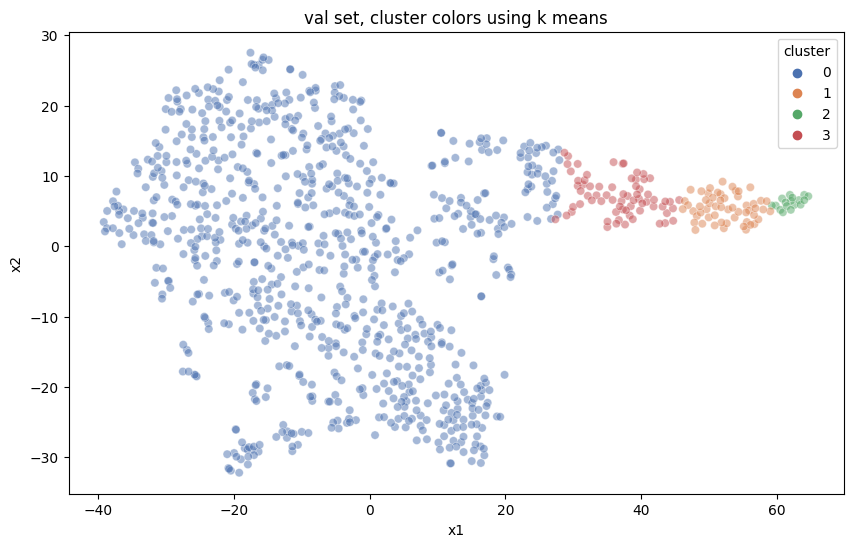

val set 0.3818980915671712
val set 0.0009092238877679862


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...

Train error for epoch 2: 0.024744151750018182


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...


Val error for epoch 2: 0.029274857736059597


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...

Train error for epoch 3: 0.02166816464584185


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...


Val error for epoch 3: 0.026410171229924475


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

 ... (more hidden) ...

Train error for epoch 4: 0.020803050969275084


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.56it/s]


Val error for epoch 4: 0.024393874619688307


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.42it/s]

Train error for epoch 5: 0.020092966692833204


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.60it/s]

Val error for epoch 5: 0.05495721846818924


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 6: 0.019791711954803934


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.46it/s]


Val error for epoch 6: 0.02475864812731743


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

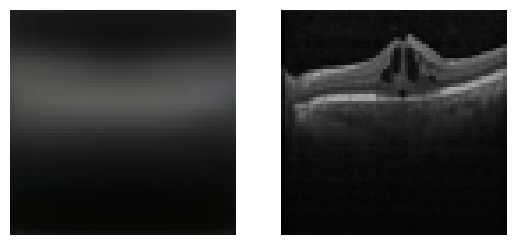

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 7: 0.019322854969042735


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.24it/s]

Val error for epoch 7: 0.02525299122290952


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 8: 0.019446926977978788


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.42it/s]

Val error for epoch 8: 0.02606140822172165


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 9: 0.018902093758395445


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.27it/s]

Val error for epoch 9: 0.02441476977297238


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 10: 0.0189406186942862


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.10it/s]


Val error for epoch 10: 0.023399184324911664


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 11: 0.01827209771051288


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.92it/s]


Val error for epoch 11: 0.023553059569426944


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

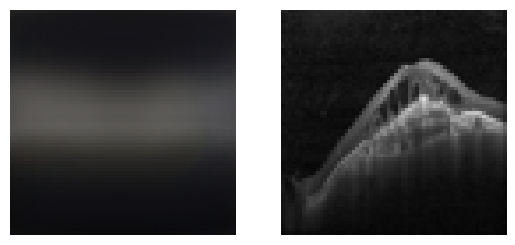

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.96it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


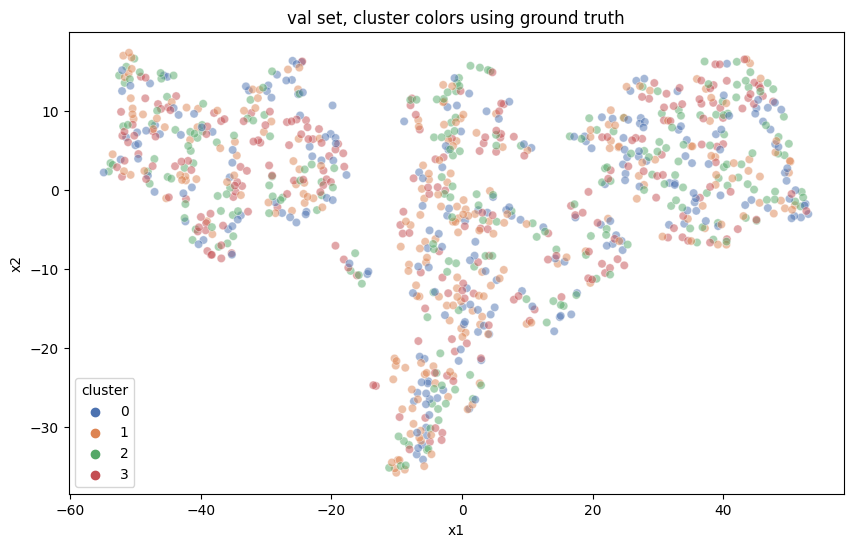

<Figure size 640x480 with 0 Axes>

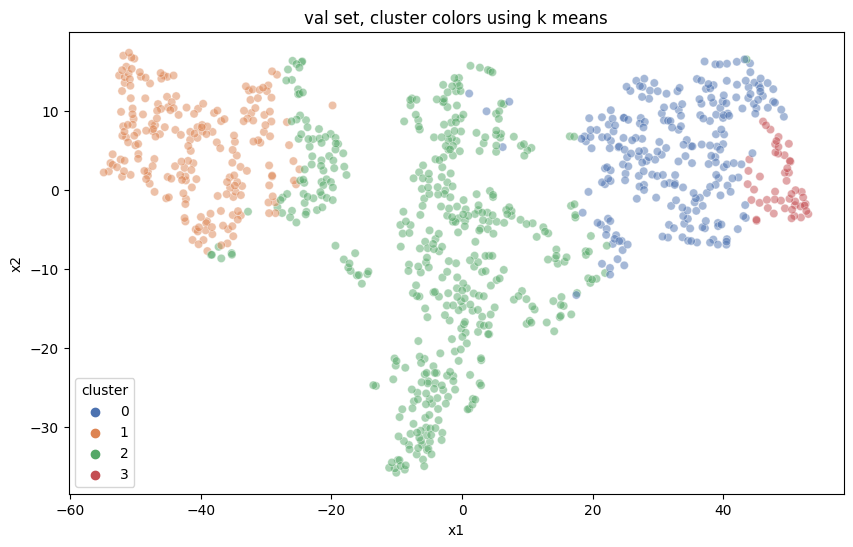

val set 0.5827535959387046
val set 0.004055386115259635


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 12: 0.14098792295409598


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.74it/s]

Val error for epoch 12: 0.03681054498468127


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 13: 0.025476782434332164


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.39it/s]

Val error for epoch 13: 0.03033093735575676


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 14: 0.021164154819786663


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.84it/s]

Val error for epoch 14: 0.026072513844285692


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.43it/s]

Train error for epoch 15: 0.02016821857577551


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.29it/s]

Val error for epoch 15: 0.025651172335658754


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 16: 0.019674364820608938


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.63it/s]


Val error for epoch 16: 0.026970848175031797


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

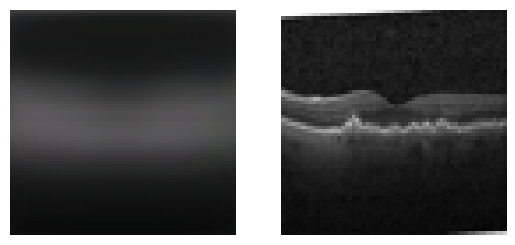

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.42it/s]

Train error for epoch 17: 0.019701692427646175


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.77it/s]

Val error for epoch 17: 0.02467080551598753


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 18: 0.019328190095994385


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.53it/s]

Val error for epoch 18: 0.025055771693587303


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 19: 0.019054537696224026


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.41it/s]

Val error for epoch 19: 0.025589637192232267


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 20: 0.018717075907223057


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.63it/s]

Val error for epoch 20: 0.024757863421525274


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 21: 0.018606305304707357


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.19it/s]


Val error for epoch 21: 0.023453937311257635


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

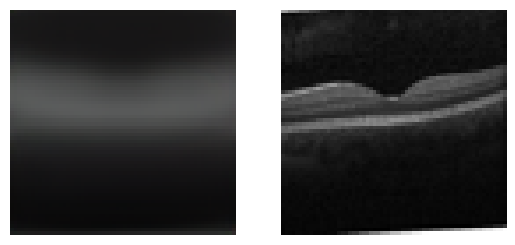

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.93it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


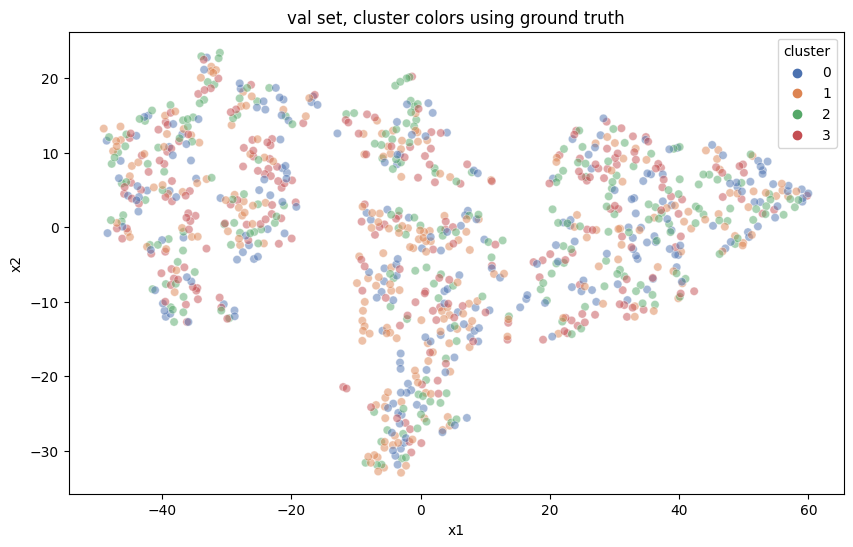

<Figure size 640x480 with 0 Axes>

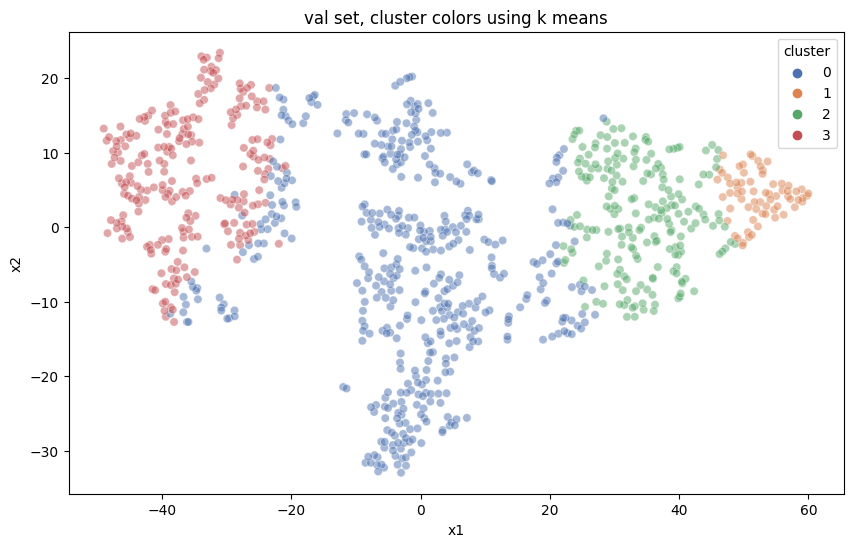

val set 0.5819181758356338
val set 0.0028494268720652867


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 22: 0.01861480006057905


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.17it/s]


Val error for epoch 22: 0.02284941396542958


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 23: 0.018417341094785825


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.00it/s]

Val error for epoch 23: 0.023798002462301935


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.41it/s]

Train error for epoch 24: 0.018116063007552197


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.64it/s]

Val error for epoch 24: 0.022947504850370542


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 25: 0.018155874382354133


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.41it/s]


Val error for epoch 25: 0.022226693108677864


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 26: 0.017785788193745485


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.34it/s]


Val error for epoch 26: 0.023639816790819168


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

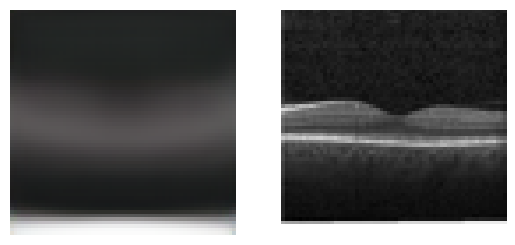

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 27: 0.021399187040291798


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.20it/s]

Val error for epoch 27: 0.022584248600261553


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 28: 0.017593961698852207


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.09it/s]

Val error for epoch 28: 0.02232485025056771


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 29: 0.017366212097330882


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.98it/s]


Val error for epoch 29: 0.02154358582837241


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 30: 0.017343098910850778


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.58it/s]

Val error for epoch 30: 0.022422067022749355


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 31: 0.017459776531368664


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.70it/s]


Val error for epoch 31: 0.022739974781870842


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

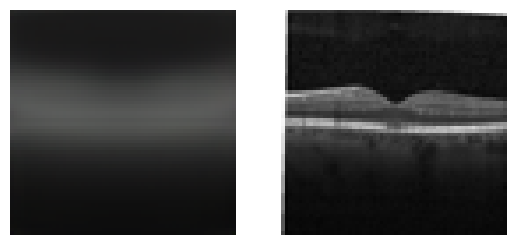

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


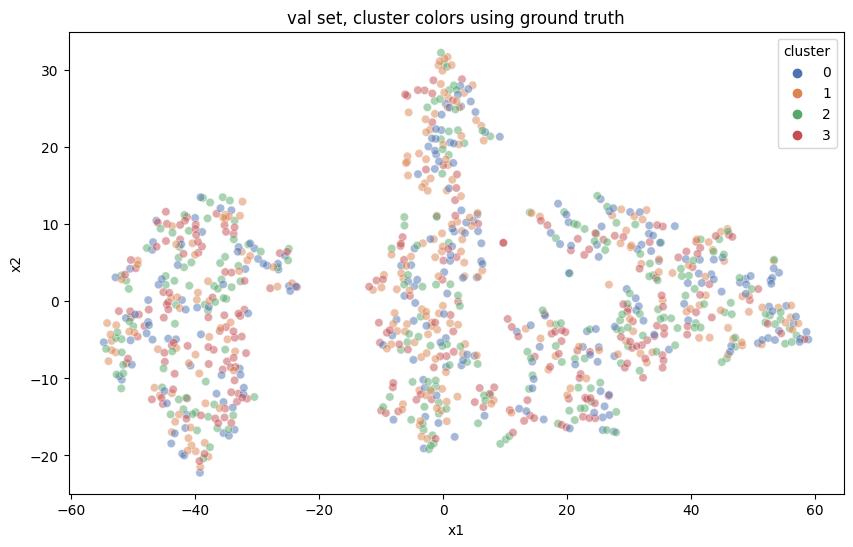

<Figure size 640x480 with 0 Axes>

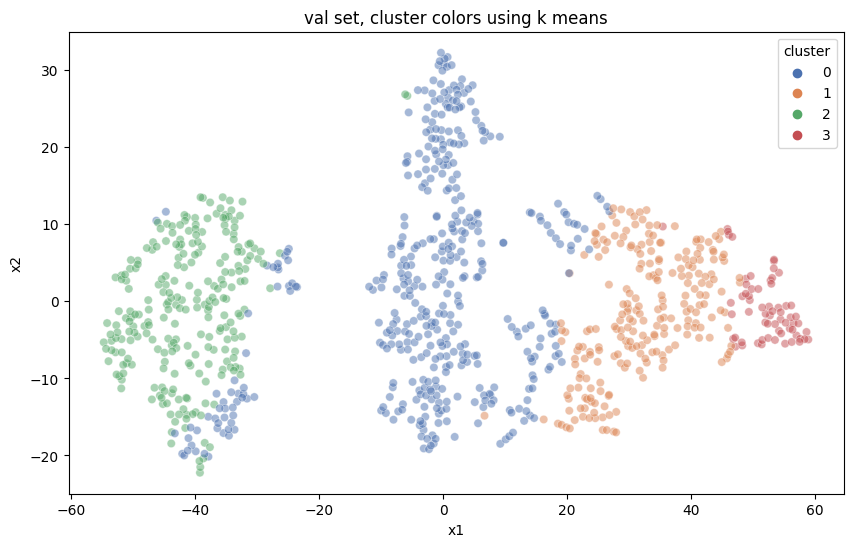

val set 0.5928299161588623
val set 0.006989151999390781


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 32: 0.017254590144427404


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.73it/s]

Val error for epoch 32: 0.02238632632153375


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 33: 0.017420741849205317


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.22it/s]

Val error for epoch 33: 0.021865983360580037


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 34: 0.028351292895392698


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.31it/s]

Val error for epoch 34: 0.022076546347567012


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.38it/s]

Train error for epoch 35: 0.01742934182665227


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.21it/s]

Val error for epoch 35: 0.02397760296506541


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.37it/s]

Train error for epoch 36: 0.017181736390301225


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.51it/s]


Val error for epoch 36: 0.022849023874316896


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

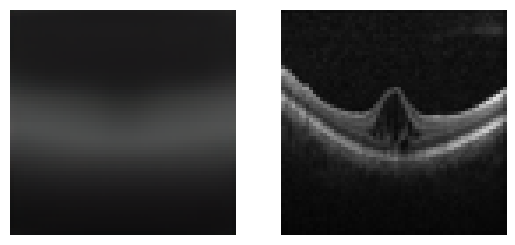

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]


Train error for epoch 37: 0.01720927833202304


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.22it/s]

Val error for epoch 37: 0.022030724212527275


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 38: 0.01706700780627366


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.04it/s]

Val error for epoch 38: 0.021586575146232332


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:37,  5.35it/s]

Train error for epoch 39: 0.0170566746893548


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.12it/s]


Val error for epoch 39: 0.02135866348232542


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:25,  6.10it/s]

Train error for epoch 40: 0.017078789893087292


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.16it/s]

Val error for epoch 40: 0.021694404738289968


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:38,  5.29it/s]

Train error for epoch 41: 0.01702398005265192


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.73it/s]


Val error for epoch 41: 0.02254687196442059


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

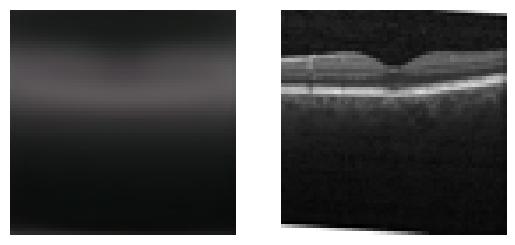

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


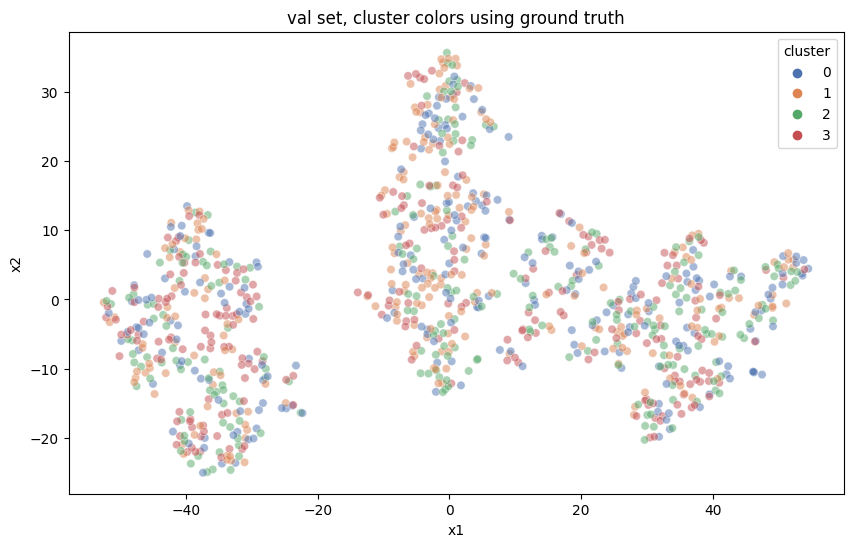

<Figure size 640x480 with 0 Axes>

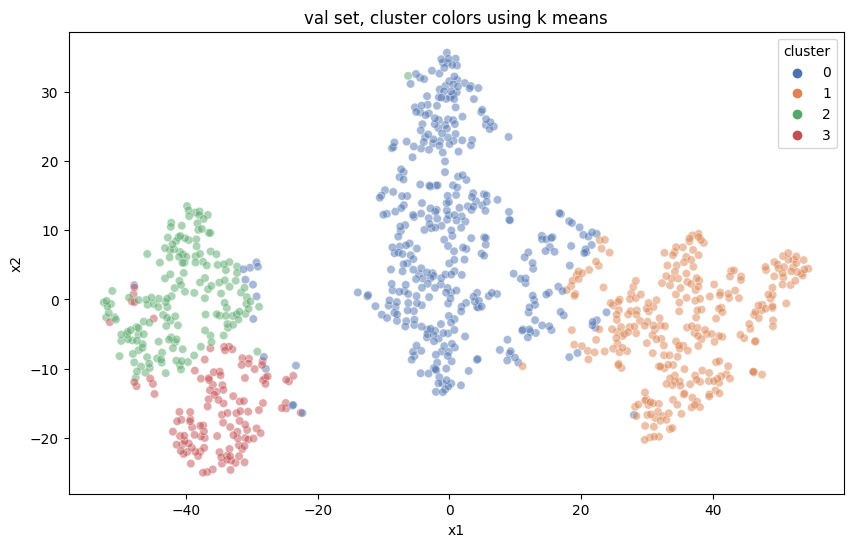

val set 0.6044958848615894
val set 0.005610869217250679


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.66it/s]

Train error for epoch 42: 0.017062988144751358


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  7.52it/s]


Val error for epoch 42: 0.021029583843691007


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:52,  4.64it/s]

Train error for epoch 43: 0.01705477887231878


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  7.27it/s]

Val error for epoch 43: 0.022164576553872654


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:53,  4.60it/s]

Train error for epoch 44: 0.016862410696262705


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.17it/s]

Val error for epoch 44: 0.021627377984779223


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.68it/s]

Train error for epoch 45: 0.016929171882898702


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.78it/s]

Val error for epoch 45: 0.021646577066608837


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:53,  4.60it/s]

Train error for epoch 46: 0.029683454192803025


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.83it/s]


Val error for epoch 46: 0.023758501080530032


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

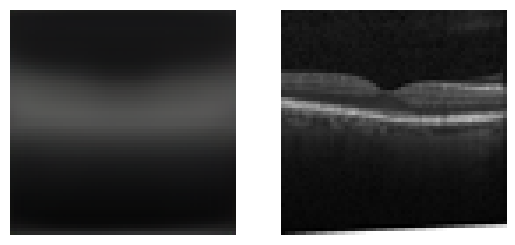

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.67it/s]

Train error for epoch 47: 0.01756850569982675


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.63it/s]

Val error for epoch 47: 0.021672473422118595


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:28,  5.89it/s]

Train error for epoch 48: 0.01704028961847531


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.38it/s]

Val error for epoch 48: 0.021723714524081776


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 49: 0.016924619150925392


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.16it/s]

Val error for epoch 49: 0.021175667643547058


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 50: 0.016822398123608442


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.18it/s]

Val error for epoch 50: 0.02157327319894518


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 51: 0.016776526638176185


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.19it/s]


Val error for epoch 51: 0.02132244807268892


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

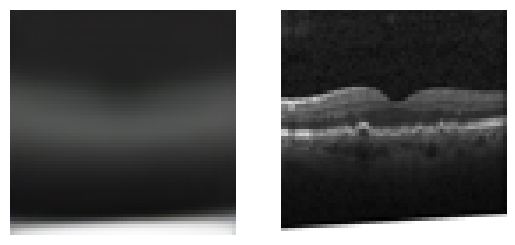

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.11it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


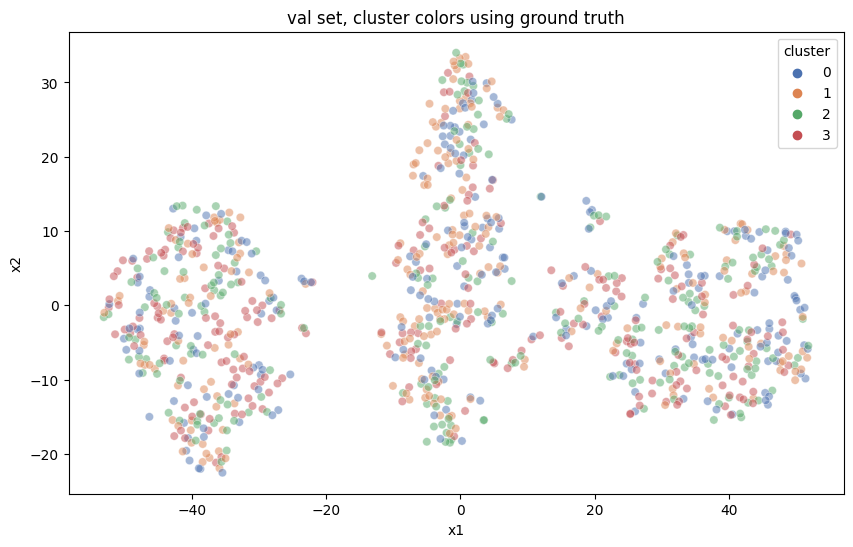

<Figure size 640x480 with 0 Axes>

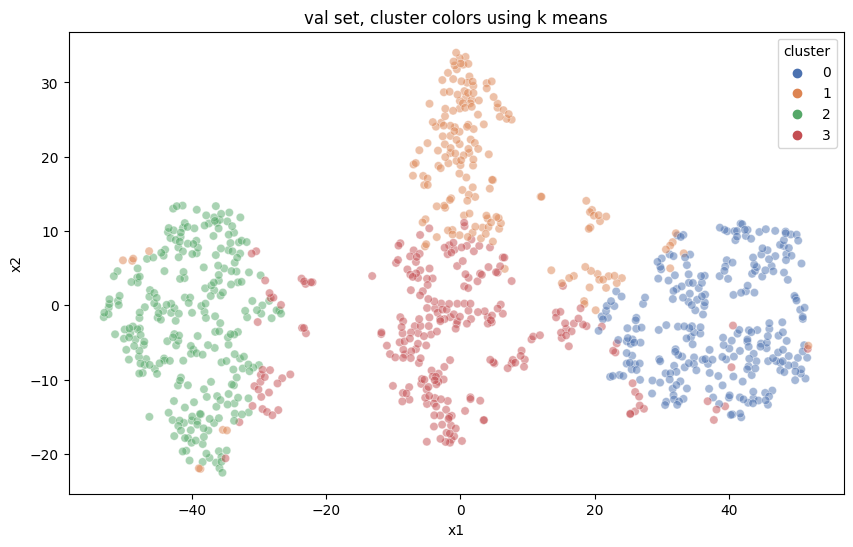

val set 0.6246228858102507
val set 0.004253225271943129


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 52: 0.01673816728643401


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.75it/s]

Val error for epoch 52: 0.021126410524759973


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 53: 0.01675104560963309


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.26it/s]

Val error for epoch 53: 0.021057387813925743


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 54: 0.016734172868937424


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.45it/s]


Val error for epoch 54: 0.02075885236263275


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 55: 0.01680818331855101


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.06it/s]

Val error for epoch 55: 0.022622394242456982


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 56: 0.016663175330080823


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.88it/s]


Val error for epoch 56: 0.020599371886679103


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

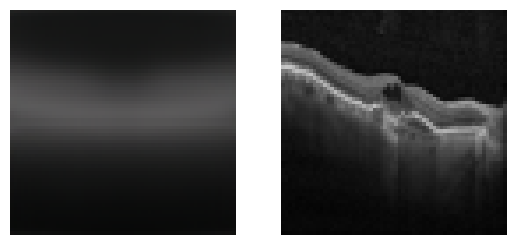

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 57: 0.01671505837045224


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.83it/s]

Val error for epoch 57: 0.02120276859828404


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 58: 0.016702928898530707


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.09it/s]

Val error for epoch 58: 0.020920257749302045


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:44,  4.98it/s]

Train error for epoch 59: 0.028035214535477294


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.60it/s]

Val error for epoch 59: 0.026640282943844795


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.67it/s]

Train error for epoch 60: 0.017442167691900726


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.55it/s]

Val error for epoch 60: 0.022010324522852898


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:53,  4.59it/s]

Train error for epoch 61: 0.017191847339415506


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.43it/s]


Val error for epoch 61: 0.023999734914728572


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

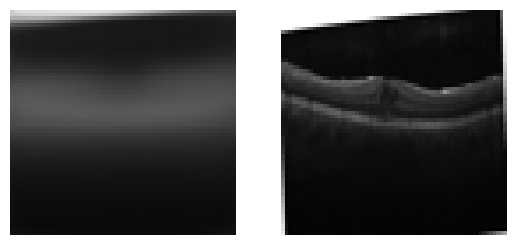

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


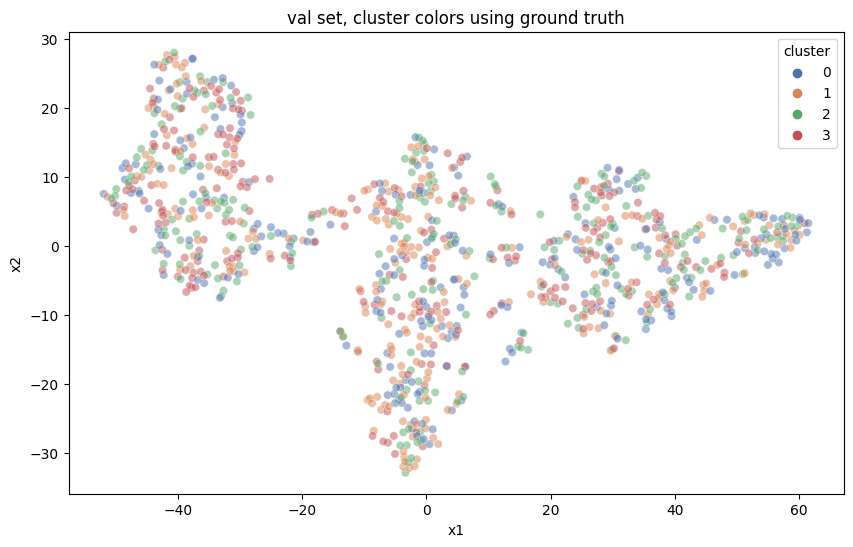

<Figure size 640x480 with 0 Axes>

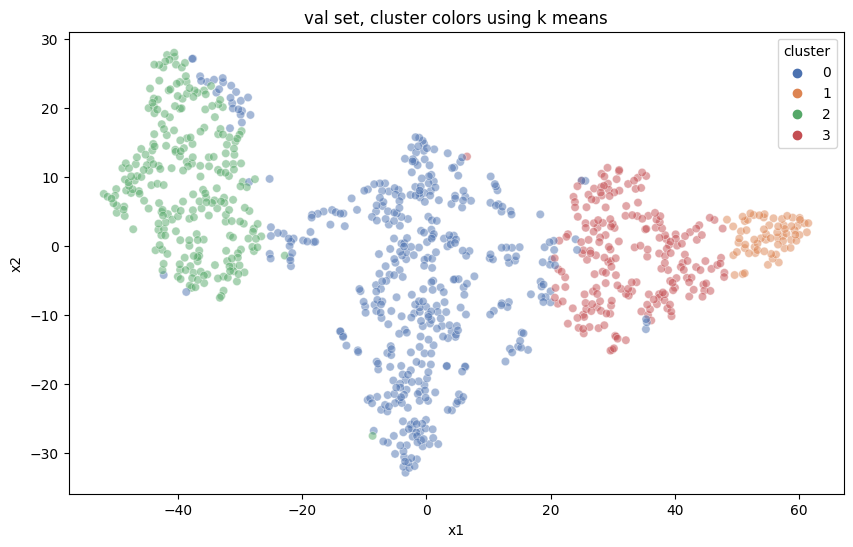

val set 0.5921632893758493
val set 0.007055351308300379


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.66it/s]

Train error for epoch 62: 0.01691445645709985


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.79it/s]

Val error for epoch 62: 0.023578664287924767


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:52,  4.66it/s]

Train error for epoch 63: 0.017004822511333194


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.76it/s]

Val error for epoch 63: 0.02168325787144048


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.70it/s]

Train error for epoch 64: 0.01676833774579864


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.88it/s]

Val error for epoch 64: 0.021133573459727422


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:51,  4.67it/s]

Train error for epoch 65: 0.01670063101827755


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.19it/s]

Val error for epoch 65: 0.022000519558787346


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:26,  6.01it/s]

Train error for epoch 66: 0.016730459623267576


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.75it/s]


Val error for epoch 66: 0.021142104108418738


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

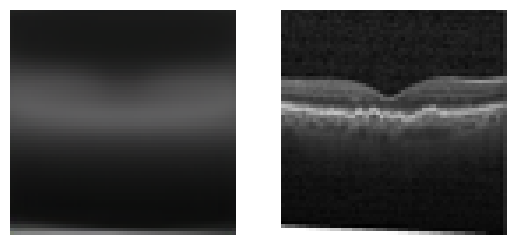

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 67: 0.016634020595069465


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.04it/s]

Val error for epoch 67: 0.021001577377319336


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.38it/s]

Train error for epoch 68: 0.016648827163563352


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.97it/s]

Val error for epoch 68: 0.021365948021411896


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.38it/s]

Train error for epoch 69: 0.017366512776879797


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.98it/s]

Val error for epoch 69: 0.021441060783607618


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 70: 0.016460717723645886


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.18it/s]

Val error for epoch 70: 0.021104013281209127


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 71: 0.016660075513163362


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.94it/s]


Val error for epoch 71: 0.0214922090194055


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

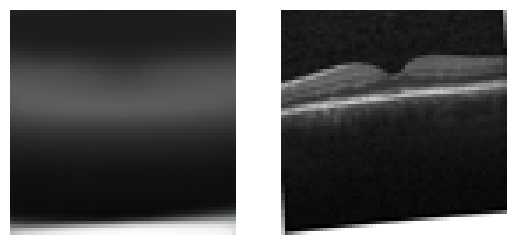

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.06it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


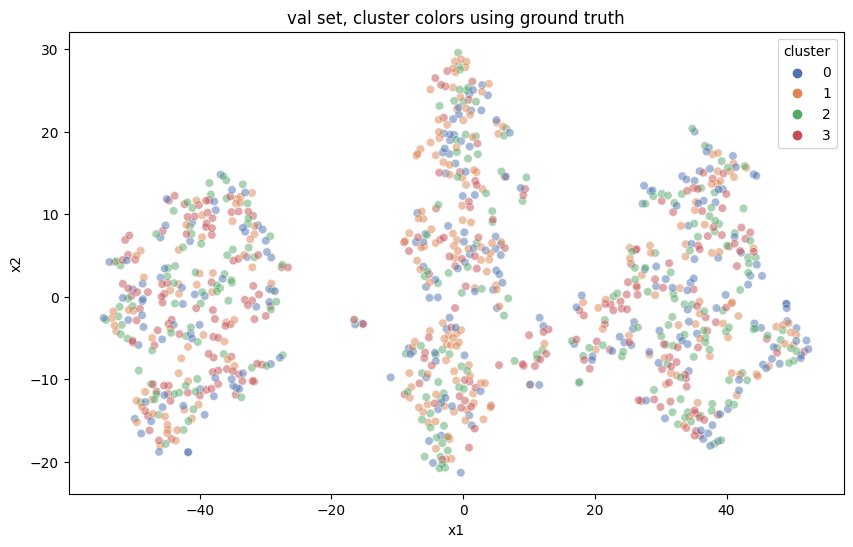

<Figure size 640x480 with 0 Axes>

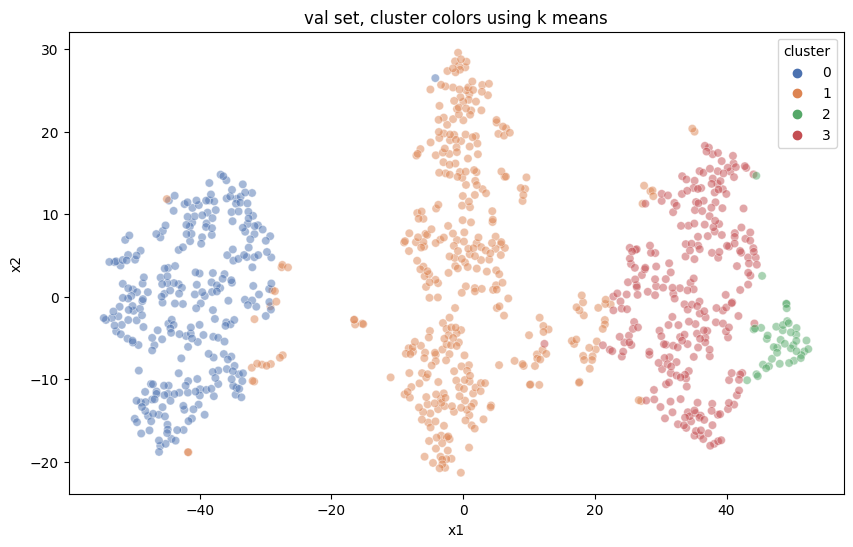

val set 0.5958318733067253
val set 0.007517068655207175


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 72: 0.01648726173445954


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.02it/s]

Val error for epoch 72: 0.020952009995068823


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 73: 0.016573200846044436


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.85it/s]

Val error for epoch 73: 0.020962579175829887


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.38it/s]

Train error for epoch 74: 0.01654311653491174


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.93it/s]

Val error for epoch 74: 0.02092509636921542


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 75: 0.016493497511118137


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.20it/s]

Val error for epoch 75: 0.02129863202571869


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:22,  6.35it/s]

Train error for epoch 76: 0.01679064891517391


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.98it/s]


Val error for epoch 76: 0.021522639585392817


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

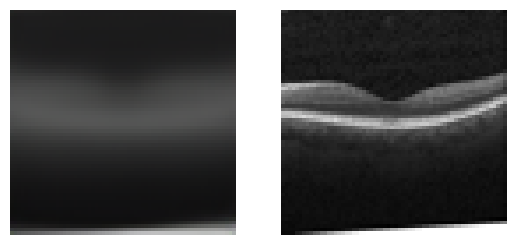

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:22,  6.34it/s]

Train error for epoch 77: 0.016455397167155474


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.03it/s]

Val error for epoch 77: 0.021863582144890512


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:22,  6.33it/s]

Train error for epoch 78: 0.01670024624619912


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.19it/s]


Val error for epoch 78: 0.020228413066693714


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 79: 0.016437202000243307


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.36it/s]

Val error for epoch 79: 0.02083489884223257


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:22,  6.33it/s]

Train error for epoch 80: 0.01648498316708373


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.01it/s]

Val error for epoch 80: 0.020839393671069826


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:41,  5.14it/s]

Train error for epoch 81: 0.018855044048014965


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:01,  6.18it/s]


Val error for epoch 81: 0.020574188392077173


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

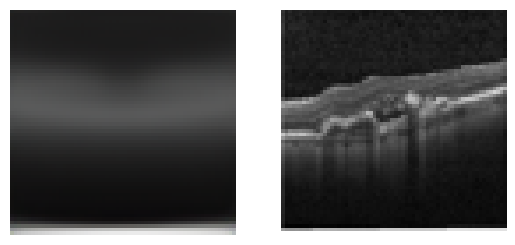

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.68it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


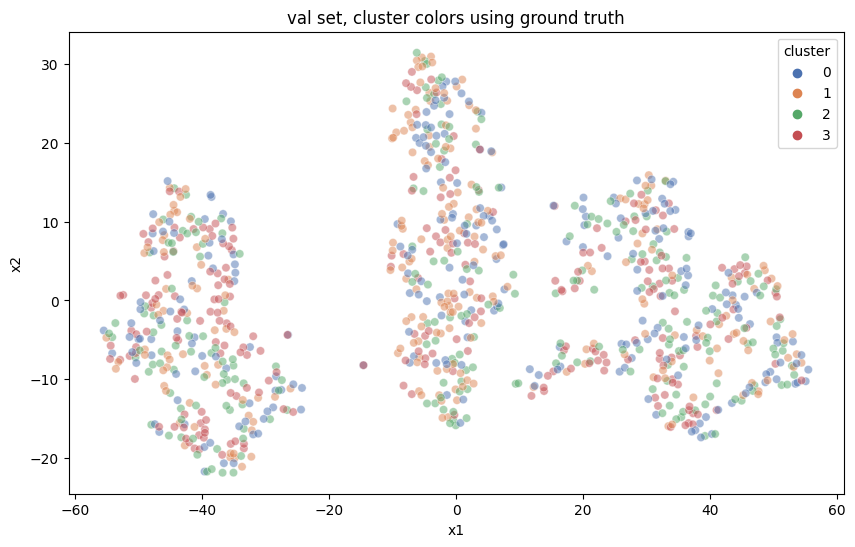

<Figure size 640x480 with 0 Axes>

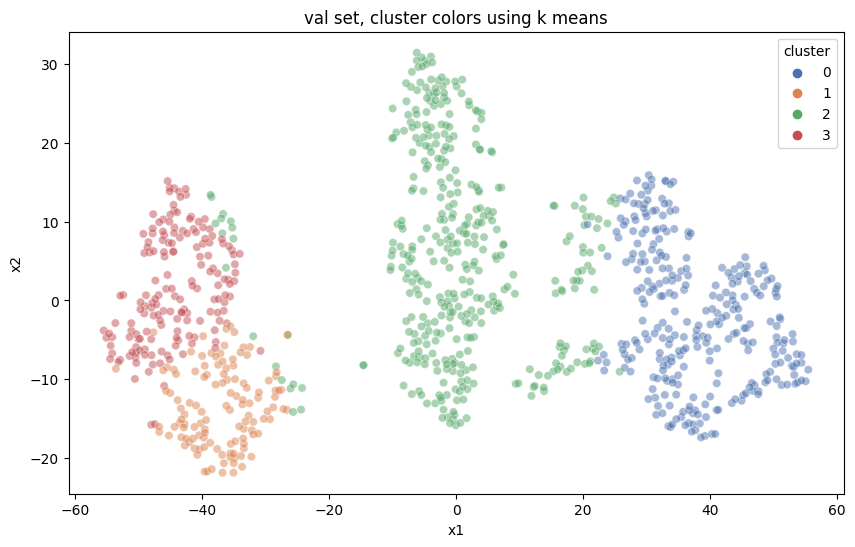

val set 0.6037224268633501
val set 0.0060015609367933


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:29,  5.81it/s]

Train error for epoch 82: 0.016386856394685848


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.96it/s]

Val error for epoch 82: 0.021020860012088503


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.38it/s]

Train error for epoch 83: 0.016277608878181214


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.66it/s]

Val error for epoch 83: 0.020399559821401323


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.38it/s]

Train error for epoch 84: 0.0162369796251896


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.85it/s]

Val error for epoch 84: 0.020282011745231494


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 85: 0.01631935549481645


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.47it/s]

Val error for epoch 85: 0.020465462867702757


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 86: 0.01623799933581801


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.30it/s]


Val error for epoch 86: 0.021258841401764324


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

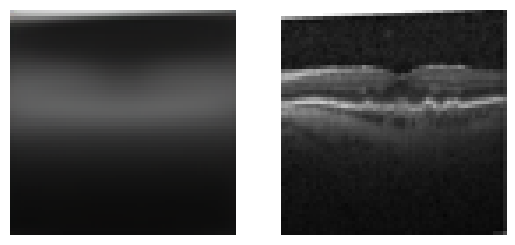

VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 87: 0.016296404254785426


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.82it/s]

Val error for epoch 87: 0.021271806210279465


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 88: 0.0163929421533321


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.98it/s]


Val error for epoch 88: 0.021301743175302233


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 89: 0.01636542540379655


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.97it/s]

Val error for epoch 89: 0.021917729505470822


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 90: 0.01630456322149844


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.06it/s]

Val error for epoch 90: 0.02084368174629552


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.39it/s]

Train error for epoch 91: 0.016241825872142002


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  9.35it/s]


Val error for epoch 91: 0.0216067268380097


(-0.5, 63.5, 63.5, -0.5)

(-0.5, 63.5, 63.5, -0.5)

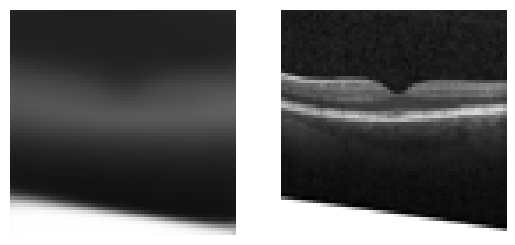

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.22it/s]
/home/prashant/anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(968, 512) (968,)


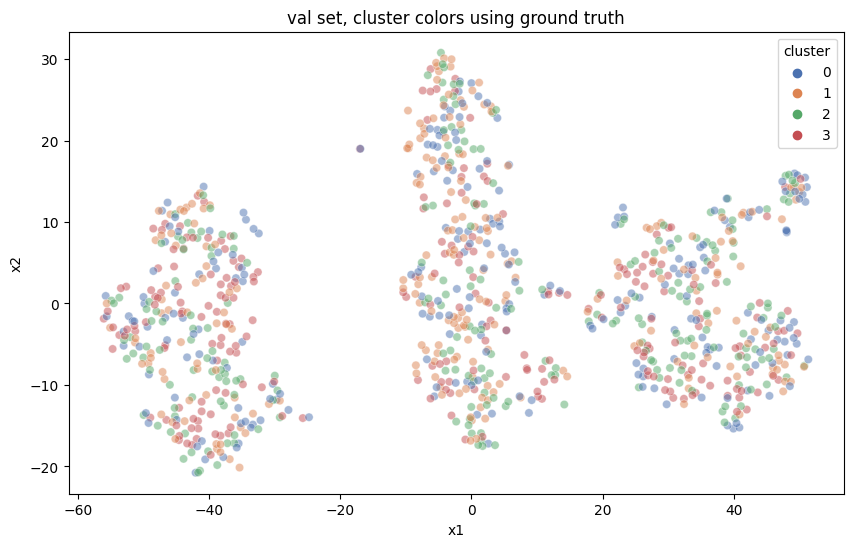

<Figure size 640x480 with 0 Axes>

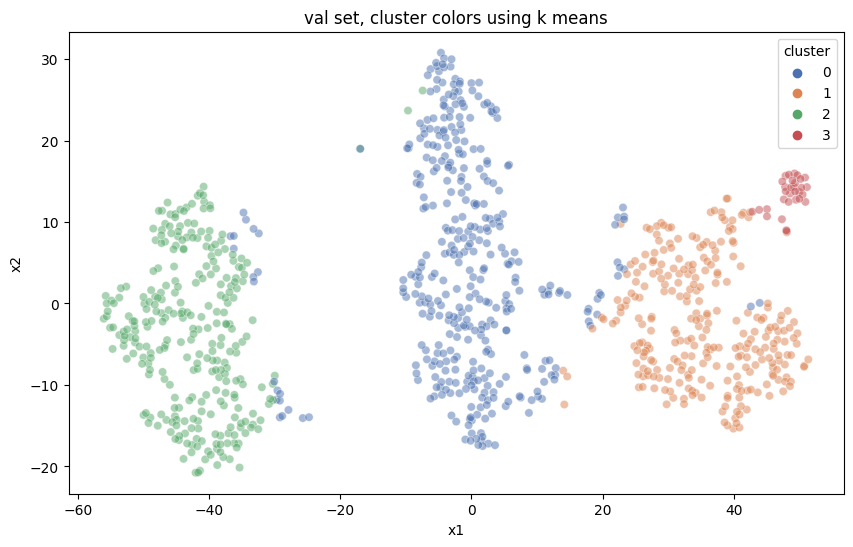

val set 0.5928149597887306
val set 0.006555432895604747


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.42it/s]

Train error for epoch 92: 0.01631331610209139


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.86it/s]

Val error for epoch 92: 0.020682825041668757


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

522it [01:21,  6.40it/s]

Train error for epoch 93: 0.016328482254052572


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

8it [00:00,  8.82it/s]

Val error for epoch 93: 0.02112660849733012


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
 

339it [00:53,  6.42it/s]

In [ ]:
use_perception=False
# error = 0
loss_log = []
best_val_error = 10e7
for epoch in range(start_epoch, nepoch):
    vae_net.train()
    error = 0
    for i, batch in tqdm(enumerate(train_loader)):
        try:
            images = batch['image']
        except:
            images = batch[0]
        
        # images = batch[0]
        # print(images.shape)
        # exit()
        images = images.to(device)
#         images = (images + 1)*0.5

        recon_img, mu, logvar = vae_net(images)
        #VAE loss
        kl_loss = kl_loss_fn(mu, logvar)
        mse_loss = F.mse_loss(recon_img, images)
        
        #Perception loss
        if use_perception:
            feat_in = torch.cat((recon_img, images), 0)
            feature_loss = feature_extractor(feat_in)
        else:
            feature_loss = 0.0
        
        loss = kl_loss + mse_loss + feature_loss
    
        loss_log.append(loss.item())
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

        error += torch.linalg.norm(loss).item()
        # i += 1
        wandb.log({"loss": loss.item(), "mse_loss": mse_loss.item(), "kl_loss": kl_loss.item(), "feature_loss": feature_loss})
    print(f"Train error for epoch {epoch + 1}: {error / i}")
    

    # eval
    vae_net.eval()
    with torch.no_grad():
        val_error = 0
        for j, batch in tqdm(enumerate(test_loader)):
            try:
                images = batch["image"]
            except:
                images = batch[0]
            images = images.to(device)
#             images = (images + 1)*0.5
            recon_img, mu, logvar = vae_net(images)
            kl_loss = kl_loss_fn(mu, logvar)
            mse_loss = F.mse_loss(recon_img, images)

            if use_perception:
                feat_in = torch.cat((recon_img, images), 0)
                feature_loss = feature_extractor(feat_in)
            else:
                feature_loss = 0.0
            
            loss = kl_loss + mse_loss + feature_loss
            val_error += torch.linalg.norm(loss).item()
            wandb.log({"val_loss": loss.item(), "val_mse_loss": mse_loss.item(), "val_kl_loss": kl_loss.item(), "val_feature_loss": feature_loss})
        print(f"Val error for epoch {epoch + 1}: {val_error / j}")

        epoch_error = val_error / j
        if epoch_error < best_val_error:
            best_val_error = epoch_error
            ckpt = {
                "epoch": epoch,
                "vae_net": vae_net.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_loss": best_val_error
            }
            torch.save(ckpt, f"/mnt/Enterprise/prashant/logs/MNIST_VAE_best.pth")
        
        if epoch % 5 == 0:
            ckpt = {
                "epoch": epoch,
                "vae_net": vae_net.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_loss": best_val_error
            }
            torch.save(ckpt, f"/mnt/Enterprise/prashant/logs/MNIST_VAE_latest.pth")
        
            for batch in test_loader:
                try:
                    images = batch["image"]
                except:
                    images = batch[0]
                images = images.to(device)
#                 images = (images + 1)*0.5
                recon_img, mu, logvar = vae_net(images)
                # display recon_img

                # Create a figure with subplots
                fig, axs = plt.subplots(1, 2)

                # Assuming `recon_img` and `images` are tensors containing grayscale images
                recon_img = ((recon_img[0].permute(1, 2, 0))).detach().cpu().numpy()
                original_img = ((images[0].permute(1, 2, 0))).detach().cpu().numpy()

                # Plot the first image
                axs[0].imshow(recon_img, cmap='gray')
                axs[0].axis('off')

                # Plot the second image
                axs[1].imshow(original_img, cmap='gray')
                axs[1].axis('off')

                # Log the figure using WandB
                wandb.log({"reconstructed_vs_original": wandb.Image(fig)})

                # Show the figure locally
                plt.show()
                break

                
        if epoch % 10 == 0:
            plot_tsne(vae_net, test_loader, configs, title='val set')


In [10]:
# def plot_tsne(model, data_loader, config, title='val set'): 
#     model.eval()
#     X = []
#     X_labels = []
#     for batch in tqdm(data_loader):
#         features, _, _ = model.encoder(batch[0].to(device))
#         features = features.view(features.size(0), -1)
#         labels = batch[1].to(device)
#         X.append(features.detach().cpu().numpy())
#         X_labels.append(labels.detach().cpu().numpy())

#     # get X and X labels
#     X = np.concatenate(X, axis=0)
#     X_labels = np.concatenate(X_labels, axis=0)
#     print(X.shape, X_labels.shape)
    
#     k = 10

#     # Create a KMeans object
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     # Get the labels for each data point
#     kmeans_labels = kmeans.labels_

#     tsne = TSNE(n_components=2, random_state=42)
#     tsne_embeddings = tsne.fit_transform(X)
#     dftsne = pd.DataFrame(tsne_embeddings)
#     dftsne['cluster'] = pd.Series(X_labels)
#     dftsne.columns = ['x1','x2','cluster']
    
#     dftsne_kmeans = dftsne.copy()
#     dftsne_kmeans['cluster'] = kmeans_labels
#     os.makedirs(f"output/{config.model_type}", exist_ok=True)
    
#     plt.figure(figsize=(10,6))
#     sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",palette="deep", alpha=0.5).set_title(title + ", cluster colors using ground truth")
#     plt.show()
#     # plt.savefig(f"output/{config.model_type}/tsne_gt.png")
#     plt.figure(figsize=(10,6))
#     sns.scatterplot(data=dftsne_kmeans,x='x1', y='x2', hue='cluster', legend='full', palette="deep", alpha=0.5).set_title(title+", cluster colors using k means")
#     plt.show()
#     # plt.savefig(f"output/{config.model_type}/tsne_kmeans.png")

#     print(title, metrics.rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))
#     print(title, metrics.adjusted_rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))

100%|██████████| 157/157 [00:05<00:00, 27.24it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 512) (10000,)


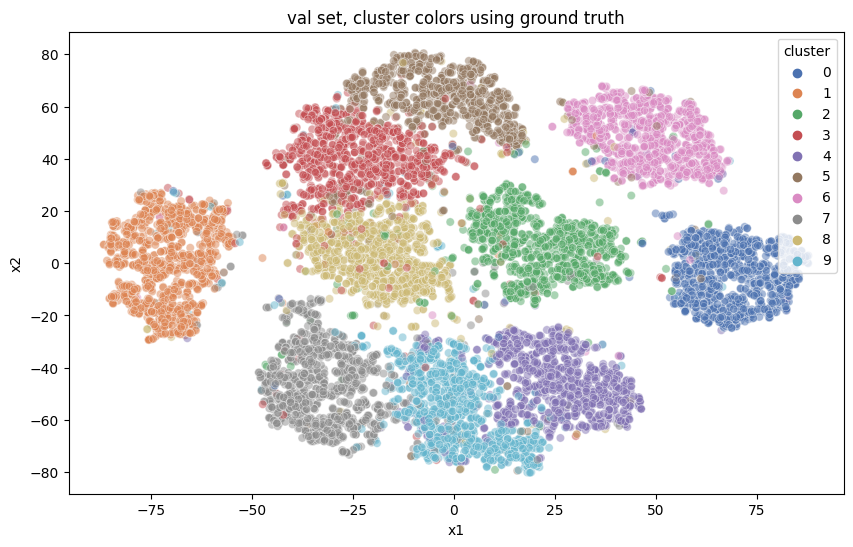

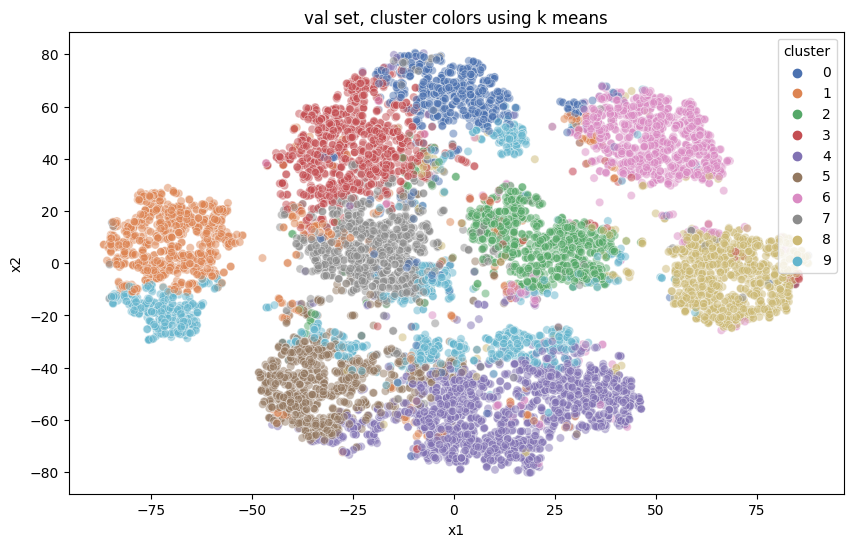

val set 0.9116764676467647
val set 0.520950264991531


In [11]:
# plot_tsne(vae_net, test_loader, configs, title='val set')

  0%|          | 0/131 [00:00<?, ?it/s]100%|██████████| 131/131 [00:19<00:00,  6.71it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16697, 512) (16697,)


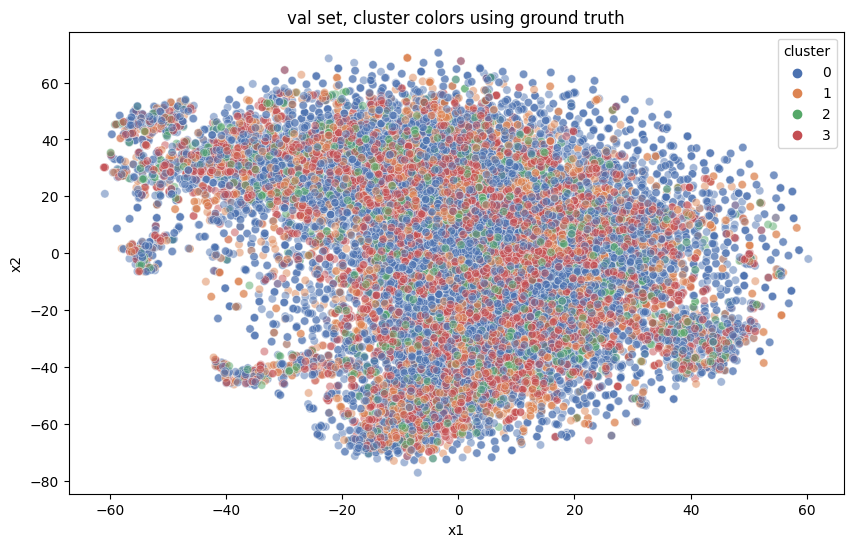

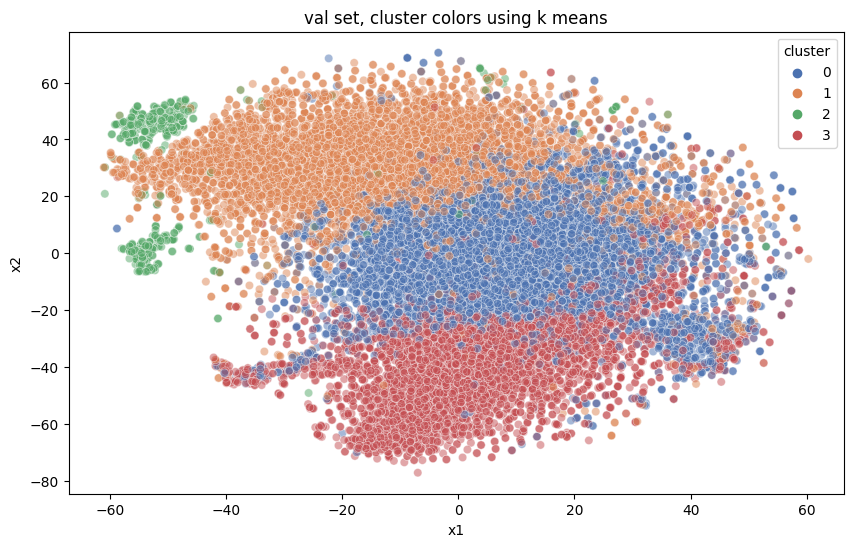

val set 0.5637158435853742
val set 0.004081442788551574


In [17]:
plot_tsne(vae_net, val_loader, configs, title='val set')